In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
path = "../data/results/VIBE_merged.csv"

df = pd.read_csv(path)

In [3]:
df.head()

,timestamp,TimeUS,IMU,VibeX,VibeY,VibeZ,Clip,label
0,2024-11-12 14:02:01,287589604,2,0.031994,0.032516,0.034765,0,0
1,2024-11-12 14:02:01,287688195,2,0.030387,0.030774,0.034655,0,0
2,2024-11-12 14:02:02,287788107,2,0.030399,0.031173,0.036004,0,0
3,2024-11-12 14:02:02,287888070,2,0.030826,0.029621,0.042018,0,0
4,2024-11-12 14:02:02,287988160,2,0.033060,0.029165,0.042596,0,0


In [5]:
len(df)

125971

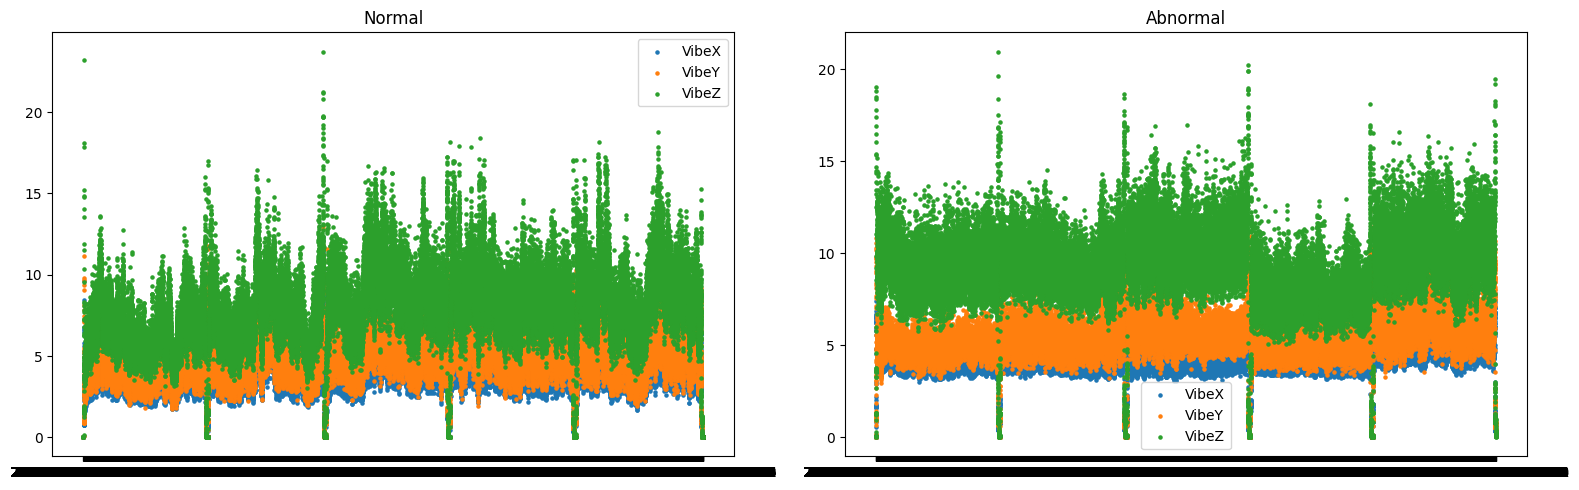

In [10]:
normal = df[df['label'] == 0]
abnormal = df[df['label'] == 1]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 정상
axes[0].scatter(normal['timestamp'], normal['VibeX'], label='VibeX', s=5)
axes[0].scatter(normal['timestamp'], normal['VibeY'], label='VibeY', s=5)
axes[0].scatter(normal['timestamp'], normal['VibeZ'], label='VibeZ', s=5)
axes[0].set_title('Normal')
axes[0].legend()

# 이상
axes[1].scatter(abnormal['timestamp'], abnormal['VibeX'], label='VibeX', s=5)
axes[1].scatter(abnormal['timestamp'], abnormal['VibeY'], label='VibeY', s=5)
axes[1].scatter(abnormal['timestamp'], abnormal['VibeZ'], label='VibeZ', s=5)
axes[1].set_title('Abnormal')
axes[1].legend()

plt.tight_layout()
plt.show()

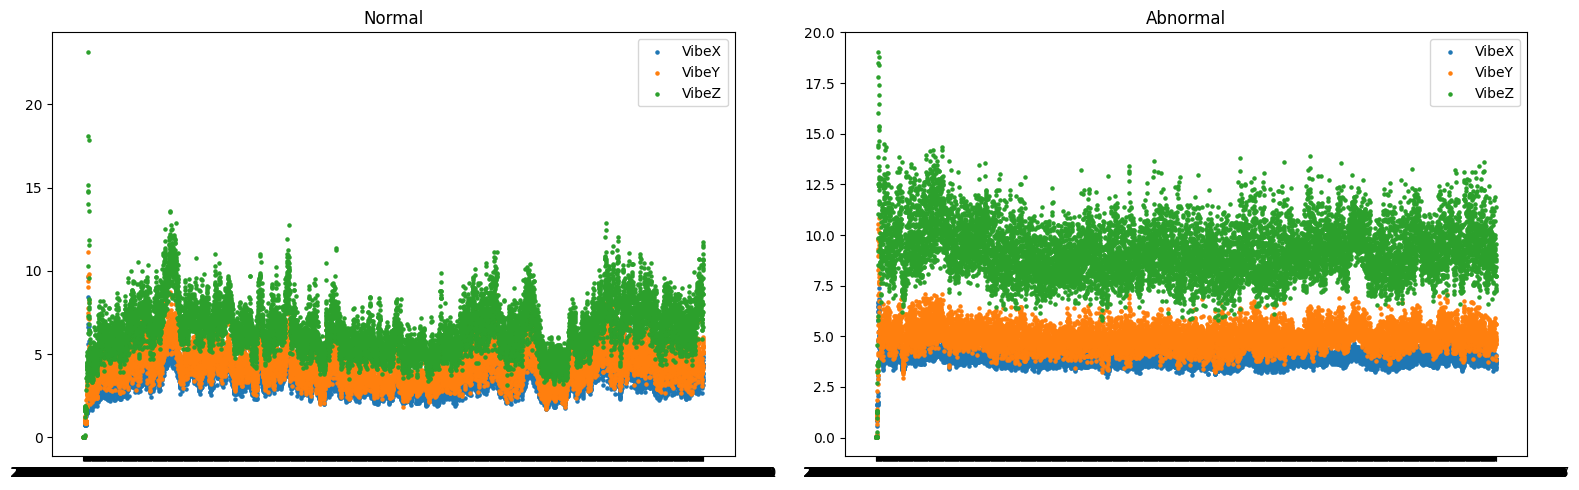

In [11]:
normal = df[df['label'] == 0].iloc[:12000]
abnormal = df[df['label'] == 1].iloc[:12000]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 정상
axes[0].scatter(normal['timestamp'], normal['VibeX'], label='VibeX', s=5)
axes[0].scatter(normal['timestamp'], normal['VibeY'], label='VibeY', s=5)
axes[0].scatter(normal['timestamp'], normal['VibeZ'], label='VibeZ', s=5)
axes[0].set_title('Normal')
axes[0].legend()

# 이상
axes[1].scatter(abnormal['timestamp'], abnormal['VibeX'], label='VibeX', s=5)
axes[1].scatter(abnormal['timestamp'], abnormal['VibeY'], label='VibeY', s=5)
axes[1].scatter(abnormal['timestamp'], abnormal['VibeZ'], label='VibeZ', s=5)
axes[1].set_title('Abnormal')
axes[1].legend()

plt.tight_layout()
plt.show()

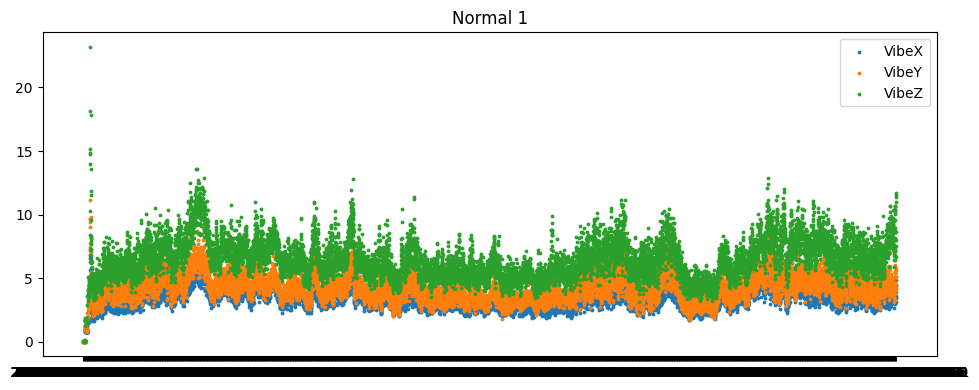

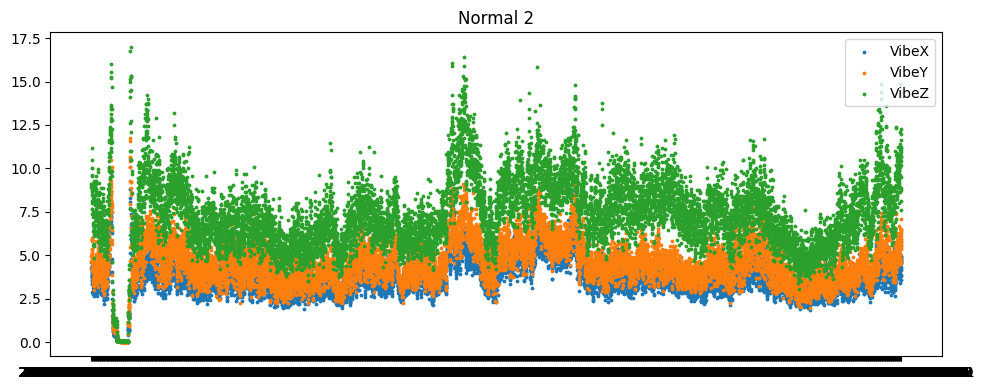

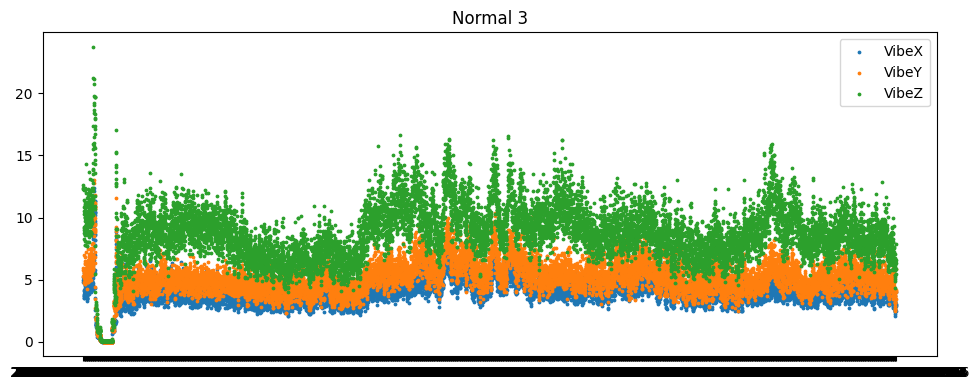

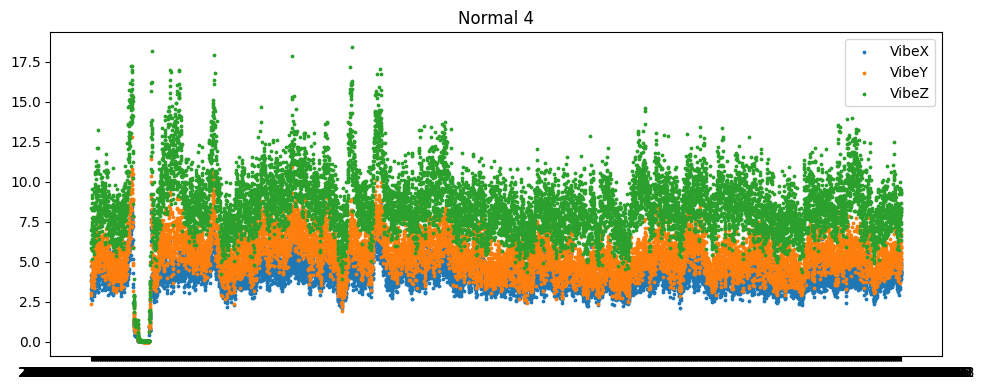

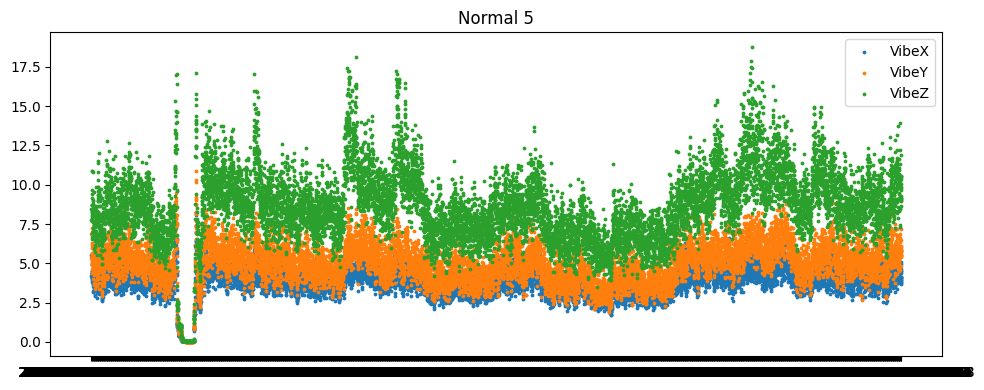

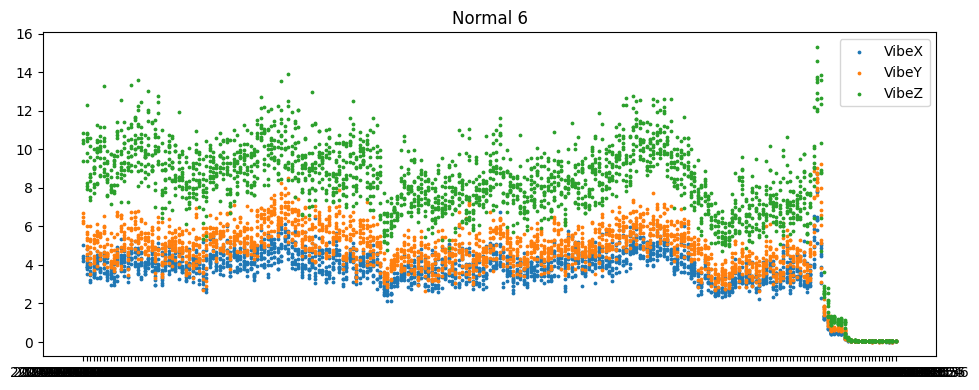

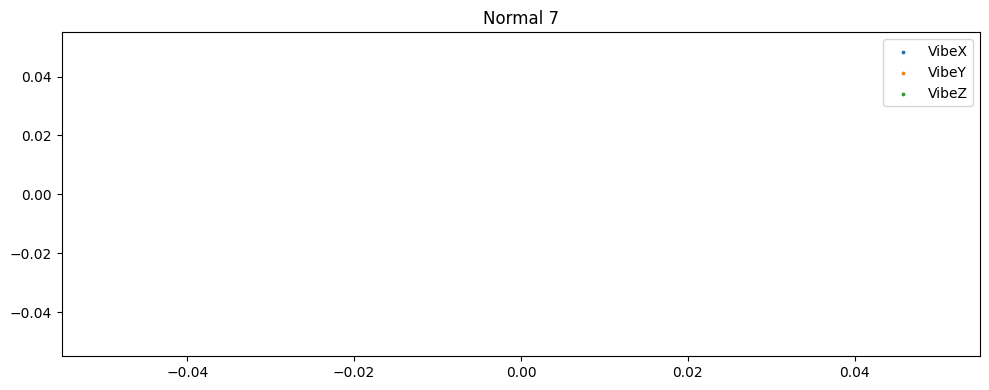

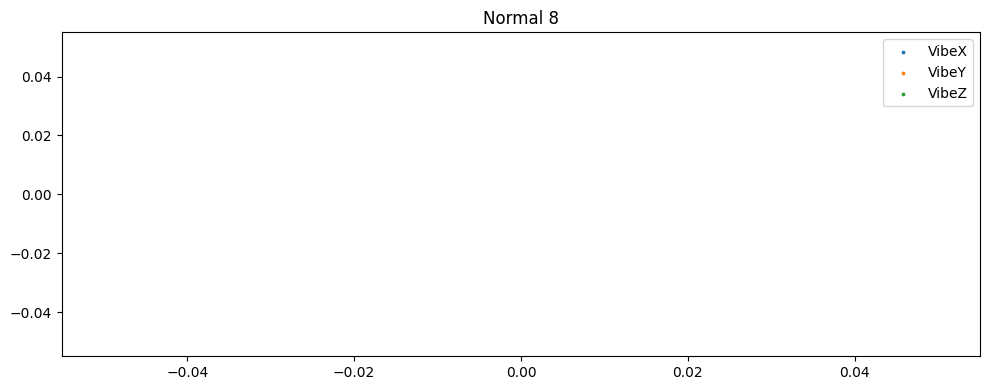

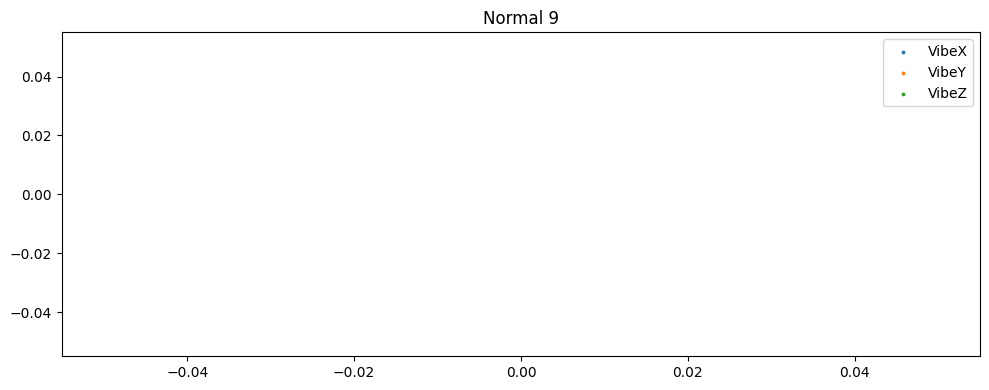

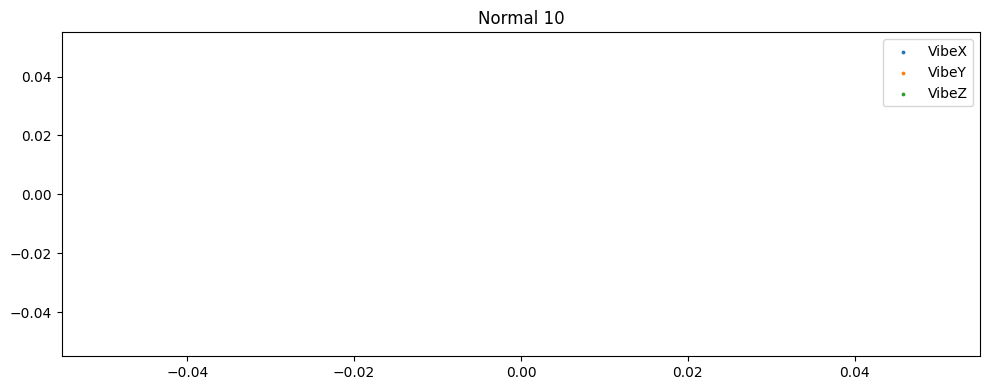

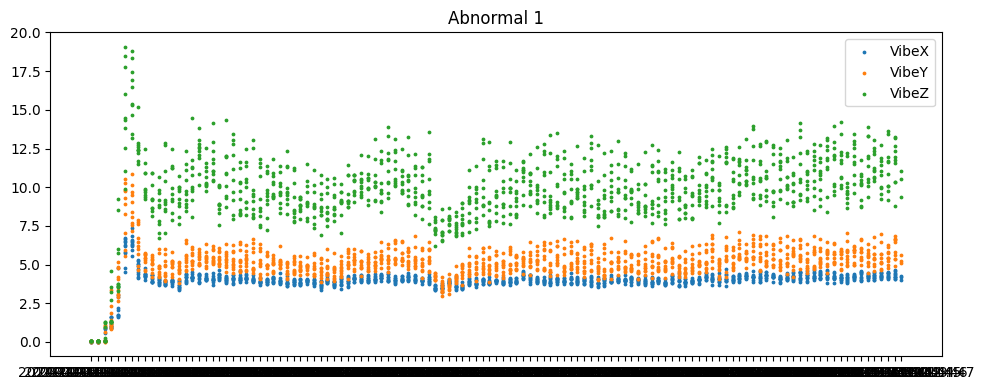

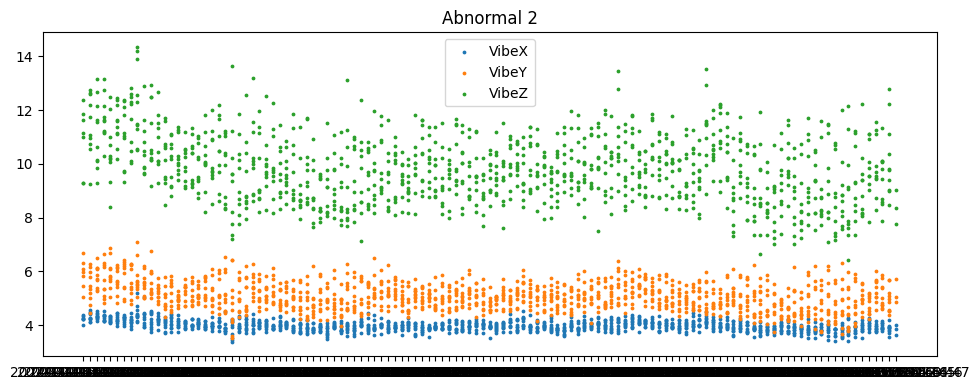

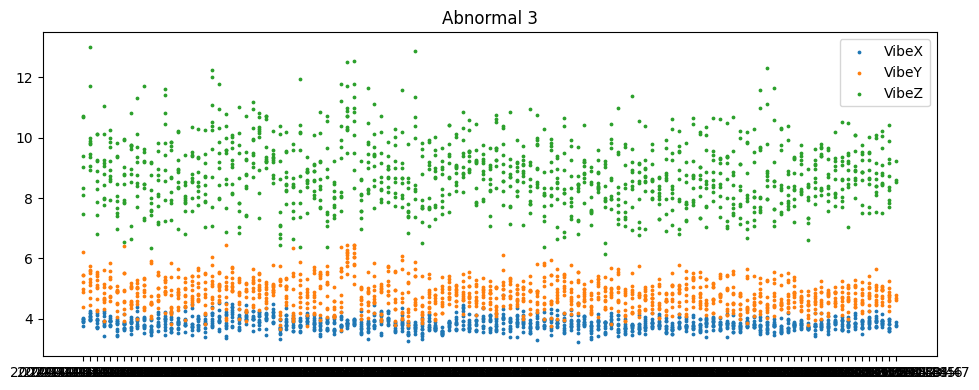

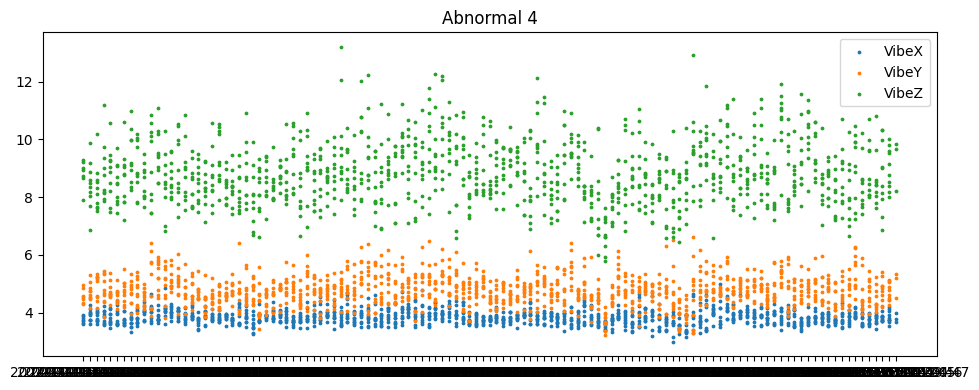

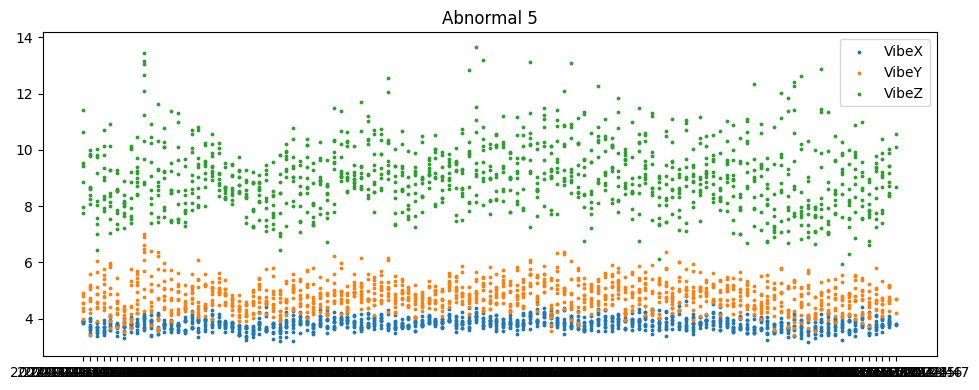

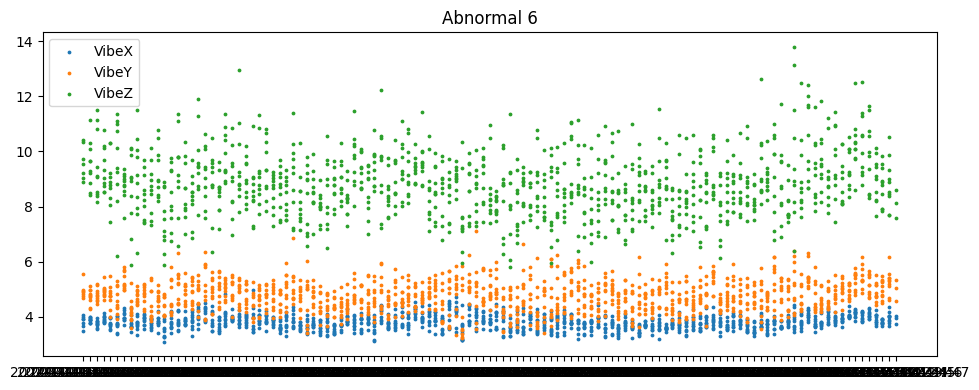

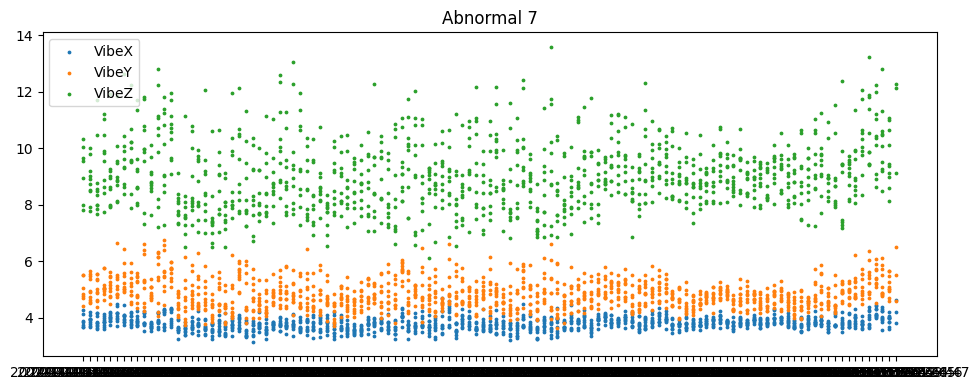

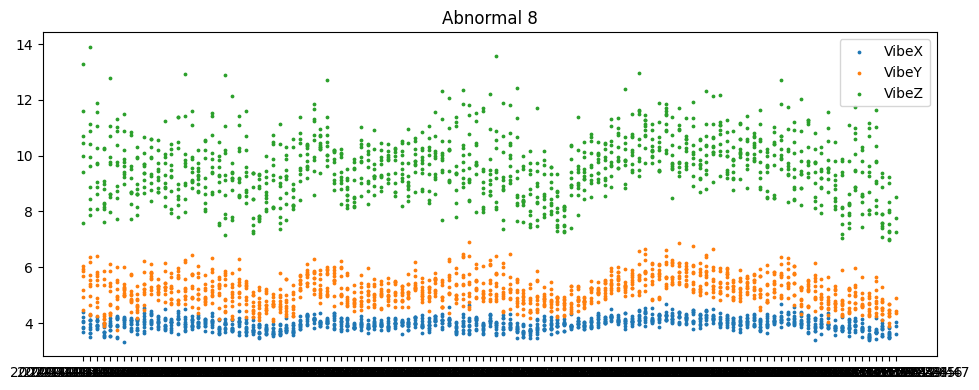

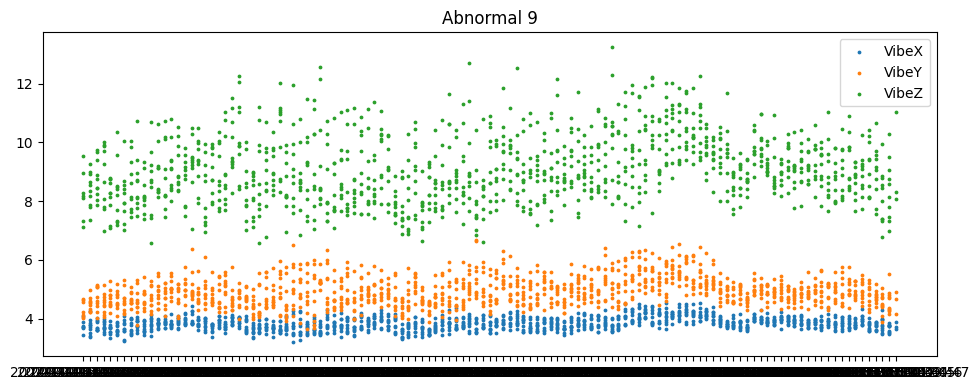

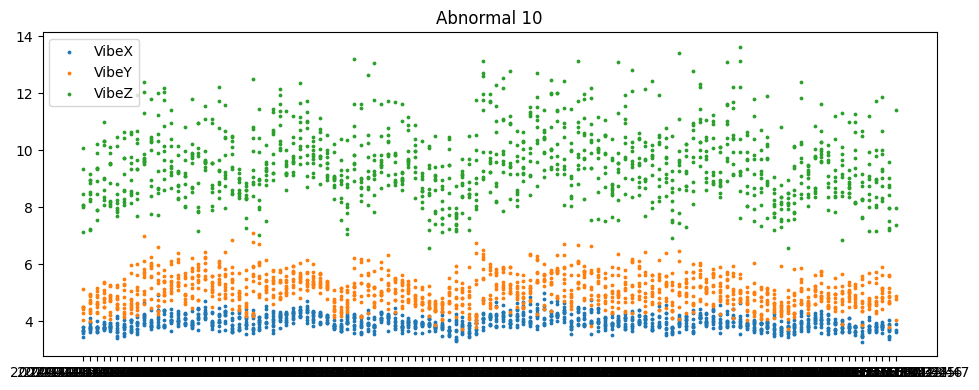

In [12]:
import matplotlib.pyplot as plt

# 데이터 슬라이싱
normal = df[df['label'] == 0]
abnormal = df[df['label'] == 1]

# Normal 10개 개별 출력
for i in range(10):
    n_slice = normal.iloc[i*12000:(i+1)*12000]
    
    plt.figure(figsize=(10, 4))
    plt.scatter(n_slice['timestamp'], n_slice['VibeX'], label='VibeX', s=3)
    plt.scatter(n_slice['timestamp'], n_slice['VibeY'], label='VibeY', s=3)
    plt.scatter(n_slice['timestamp'], n_slice['VibeZ'], label='VibeZ', s=3)
    plt.title(f'Normal {i+1}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Abnormal 10개 개별 출력
for i in range(10):
    a_slice = abnormal.iloc[i*1200:(i+1)*1200]
    
    plt.figure(figsize=(10, 4))
    plt.scatter(a_slice['timestamp'], a_slice['VibeX'], label='VibeX', s=3)
    plt.scatter(a_slice['timestamp'], a_slice['VibeY'], label='VibeY', s=3)
    plt.scatter(a_slice['timestamp'], a_slice['VibeZ'], label='VibeZ', s=3)
    plt.title(f'Abnormal {i+1}')
    plt.legend()
    plt.tight_layout()
    plt.show()
